In [1]:
import sys
sys.path.append('..')

from utils import *
from model import *
# from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from PIL import Image
%load_ext autoreload
%autoreload 2

In [2]:
root_dir = "/mnt/petrelfs/sihaozhe/fs_micro2/"

In [3]:
dataset_config = {
    'root_dir': root_dir,
    'shuffle': True,
    'img_num':  50, 
    'visible_img': 5,
    # 'focus_dist': [.3, .45, .75, 1.2, 1.8],
    'focus_dist': np.linspace(0.1, 0.14, 100),
    'recon_all': True,
    'near': 0.1,
    'RGBFD': True,
    'DPT': True,
    'AIF': False,
    'far': 1,
}

In [17]:
train_dl, val_dl, test_dl = load_data(dataset_config, "DefocusNet", 1)

5 out of 50 images per sample are visible for input
Total number of training sample: 100
Total number of testing sample: 100
Total number of testing sample: 100


In [ ]:
gt_dpt = test_dl.dataset[0]['dpt'][0].unsqueeze(-1).numpy()
plt.imshow(gt_dpt)
np.max(gt_dpt)

In [124]:
fs = test_dl.dataset[0]['output'][::2,:3,:,:]

In [125]:
diff_fs = fs[1:] - fs[:-1]

In [126]:
diff_fs.shape

torch.Size([24, 3, 256, 256])

In [127]:
diff = torch.mean(diff_fs[:, :, 151, 151], dim=1)
diff

tensor([ 0.0026,  0.0013,  0.0013, -0.0013,  0.0000,  0.0039, -0.0039, -0.0013,
         0.0000, -0.0039,  0.0039,  0.0052,  0.0026,  0.0013, -0.0222, -0.0418,
         0.0510,  0.0052, -0.0693,  0.0601,  0.0052,  0.0039,  0.0000,  0.0013])

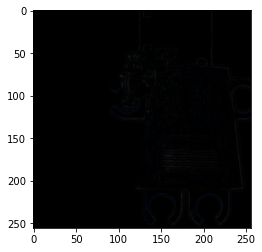

In [128]:
samp = diff_fs[17].numpy().transpose(1, 2, 0)
plt.imshow(np.abs(samp))

In [129]:
# torch.argmin(abs(diff[20:30]))

In [130]:
np.argmin(abs(np.linspace(0.1, 0.9, 25) - gt_dpt[151, 151, 0]))

8

In [131]:
gt_dpt[151, 151, 0]

0.35986328

In [132]:
np.linspace(0.1, 0.9, 25)[8]

0.3666666666666667

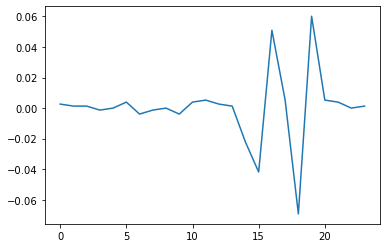

In [133]:
plt.plot(np.arange(24), diff)

In [21]:
max_d = 0
min_d = 0

for data in tqdm(train_dl.dataset):
    gt_dpt = data['dpt'][0].unsqueeze(-1).numpy()
    max_dpt = np.max(gt_dpt)
    min_dpt = np.min(gt_dpt)
    if max_d < max_dpt:
        max_d = max_dpt
    if min_d > min_dpt:
        min_d = min_dpt

  0%|          | 0/250 [00:00<?, ?it/s]

In [22]:
max_d

1.0142299

In [23]:
min_d

0

0.98828125

In [74]:
dl = iter(train_dl)

In [75]:
a = next(dl)

In [76]:
a['output'][0].shape

torch.Size([50, 3, 256, 256])

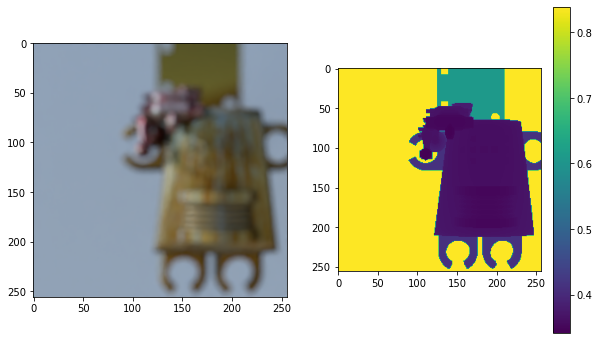

In [77]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(a['output'][0][0].numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(a['dpt'][0].numpy().transpose(1, 2, 0))
plt.colorbar()

In [14]:
dpt = a['dpt'][0]
dpt.shape

torch.Size([1, 256, 256])

In [15]:
# aif = a['aif'][0].unsqueeze(0)

In [16]:
def thin_len_coc(FN, dpt, focal_length, focus_dist, pixel_size=1.21e-5):
    sensor_dist = focus_dist * focal_length / (focus_dist - focal_length)
    D =  focal_length / FN
    CoC = D * sensor_dist * (1/focal_length - 1/sensor_dist - 1/dpt)
    sigma = CoC / 2 / pixel_size
    return torch.abs(sigma)

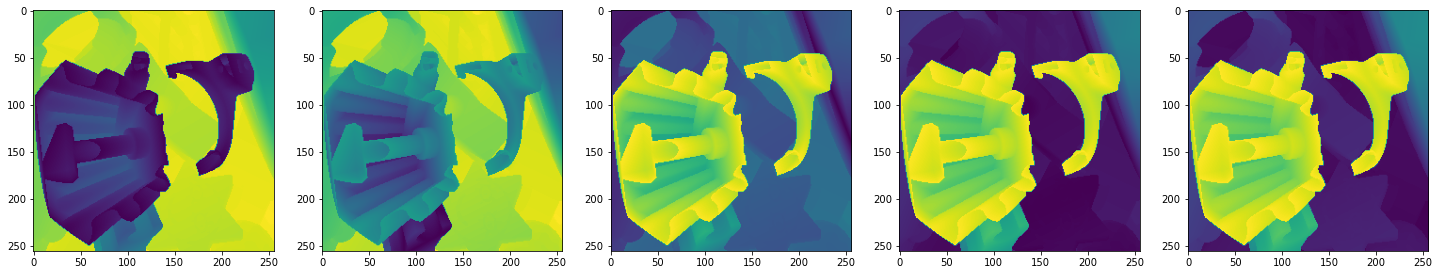

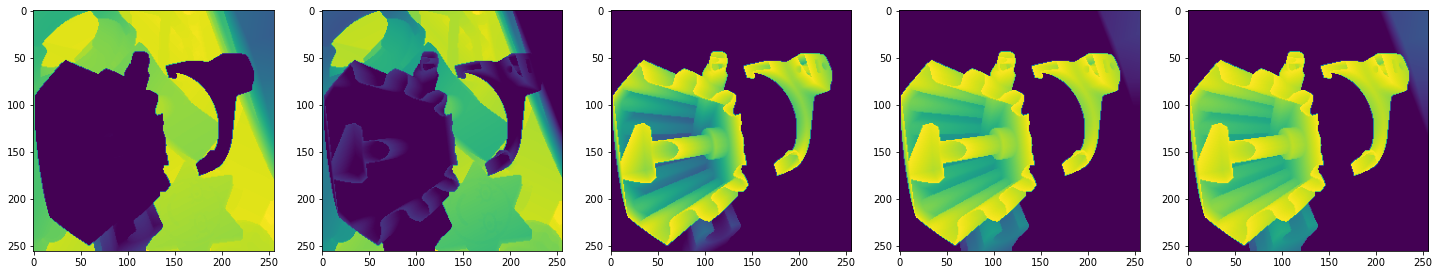

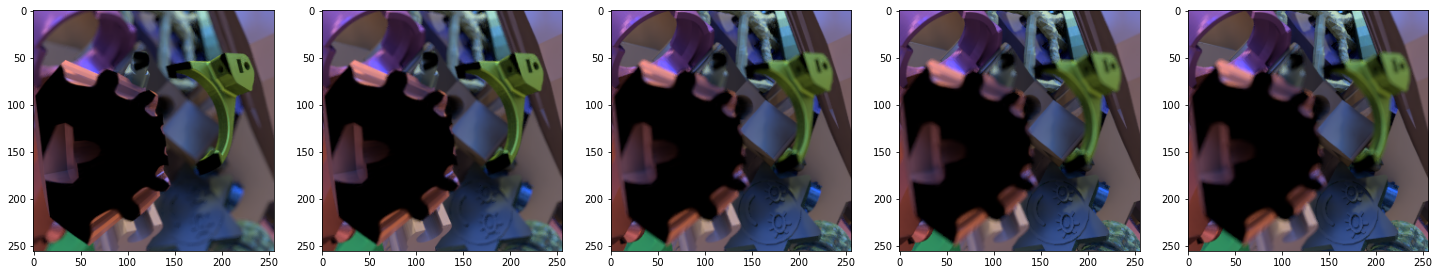

In [17]:
defocuses = []
plt.figure(figsize=(25, 6))
for i, fd in enumerate([0.1, 0.15, 0.3, 0.7, 1.5]):
    plt.subplot(1, 5, i+1)
    defocus = thin_len_coc(1, dpt, 2.9*1e-3, fd)
    defocuses.append(defocus.unsqueeze(0))
    plt.imshow(defocus.numpy().transpose(1, 2, 0))

plt.figure(figsize=(25, 6))
for i, fd in enumerate([0.1, 0.15, 0.3, 0.7, 1.5]):
    plt.subplot(1, 5, i+1)
    defocus = thin_len_coc(1, dpt, 2.9*1e-3, fd)
    plt.imshow(np.clip(defocus.numpy().transpose(1, 2, 0), 1, np.inf))
    
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(a['output'][0, i].numpy().transpose(1, 2, 0))

In [50]:
torch.cuda.set_device(5)
render = GaussPSF(7)
render.cuda()

GaussPSF()

In [51]:
recon = render(aif.cuda(), defocus.cuda())

NameError: name 'aif' is not defined

NameError: name 'recon' is not defined

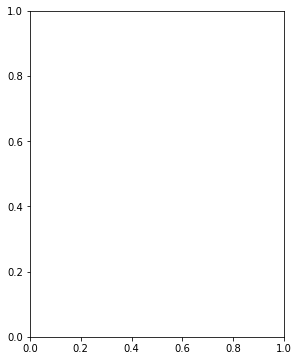

In [52]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(recon.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(a['output'][0, -1].numpy().transpose(1, 2, 0))

In [16]:
recon_loss = BlurMetric('recon')
sharp_loss = BlurMetric('sharp')
ssim_loss = BlurMetric('ssim')
l1_loss = BlurMetric('l1')
mse_loss = BlurMetric('mse')

In [17]:
recon_loss(recon, a['output'][0, -1].unsqueeze(0).cuda())

tensor(0.0171, device='cuda:5')

In [18]:
sharp_loss(recon, a['output'][0, -1].unsqueeze(0).cuda())

tensor(0.0434, device='cuda:5')

In [19]:
defocus_ = torch.cat(defocuses).squeeze()

In [20]:
aif_ = aif.expand(5, *aif.shape[1:]).contiguous()

In [21]:
recon_ = render(aif_.cuda(), defocus_.cuda())

In [22]:
metric_recon = np.zeros((6, 6))
metric_sharp = np.zeros((6, 6))
metric_ssim = np.zeros((6, 6))
metric_l1 = np.zeros((6, 6))
metric_mse = np.zeros((6, 6))

In [23]:
recon_loss(recon_[0].unsqueeze(0), a['output'][:, 0].cuda())

tensor(0.0136, device='cuda:5')

In [41]:
for i in range(6):
    for j in range(6):
        if i != 5:
            inp = recon_[i].unsqueeze(0)
        else:
            inp = a['aif'].cuda()
        if j != 5:
            tar = a['output'][:, j].cuda()
        else:
            tar = a['aif'].cuda()
        metric_recon[i, j] = recon_loss(inp, tar).item()
        metric_sharp[i, j] = sharp_loss(inp, tar).item()
        metric_ssim[i, j] = ssim_loss(inp, tar).item()        
        metric_l1[i, j] = l1_loss(inp, tar).item()
        metric_mse[i, j] = l1_loss(inp, tar).item()                

In [25]:
for i in range(6):
    for j in range(6):
        if i != 5:
            inp = a['output'][:, i].cuda()
        else:
            inp = a['aif'].cuda()
        if j != 5:
            tar = a['output'][:, j].cuda()
        else:
            tar = a['aif'].cuda()
        metric_recon[i, j] = recon_loss(inp, tar).item()
        metric_sharp[i, j] = sharp_loss(inp, tar).item()
        metric_ssim[i, j] = ssim_loss(inp, tar).item()        
        metric_l1[i, j] = l1_loss(inp, tar).item()        
        metric_mse[i, j] = l1_loss(inp, tar).item()  

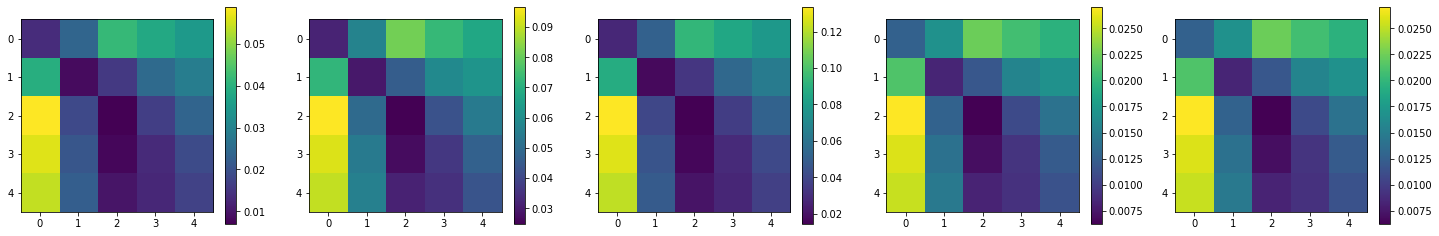

In [42]:
plt.figure(figsize=(25, 4))
for i, n in enumerate([metric_recon, metric_sharp, 1-metric_ssim, metric_l1, metric_mse]):
    plt.subplot(1, 5, i+1)
    plt.imshow(n[:5, :5])
    plt.colorbar()

In [27]:
def gradient(inp):
    D_dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    D_dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    return D_dx, D_dy

def sharpness(image):
    grad = gradient(image)
    mu = F.avg_pool2d(image, 7, 1, 7 // 2, count_include_pad=False) + 1e-8
    output = - (grad[0]**2 + grad[1]**2) - torch.abs((image - mu) / mu) - torch.pow(image - mu, 2)
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


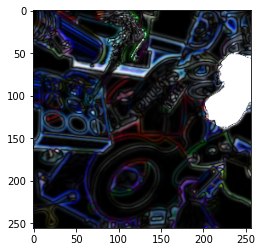

In [28]:
plt.imshow(-sharpness(recon_[0].unsqueeze(0))[0].cpu().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


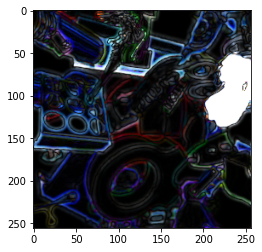

In [29]:
plt.imshow(-sharpness(a['output'][:, 0].cuda())[0].cpu().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


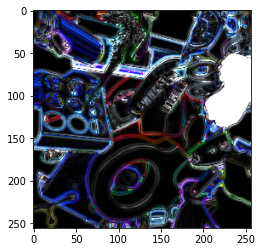

In [30]:
plt.imshow(-sharpness(a['aif'][:].cuda())[0].cpu().numpy().transpose(1, 2, 0))

In [31]:
clear_pix = torch.min(defocus_, dim=0)

In [32]:
clear_pix[1].view(256, 256, 1).shape

torch.Size([256, 256, 1])

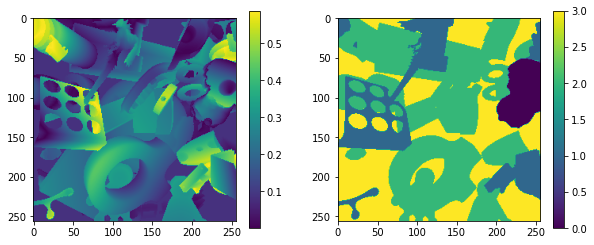

In [33]:
plt.figure(figsize=(10, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(clear_pix[i].numpy())
    plt.colorbar()

In [34]:
coarse_aif = torch.zeros(3, 256, 256)
for i in range(256):
    for j in range(256):
        coarse_aif[:, i, j] = a['output'][0][int(clear_pix[1][i, j]), :, i, j]

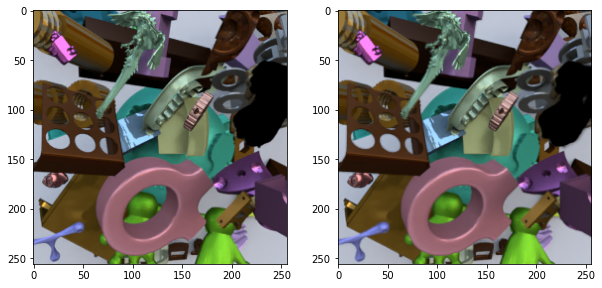

In [35]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(a['aif'][0].numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(coarse_aif.numpy().transpose(1, 2, 0))

In [36]:
recon_loss(a['aif'], coarse_aif.unsqueeze(0))

tensor(0.0051)

In [37]:
ssim_loss(a['aif'], coarse_aif.unsqueeze(0))

tensor(0.9898)

In [38]:
l1_loss(a['aif'], coarse_aif.unsqueeze(0))

tensor(0.0052)

In [39]:
sharp_loss(a['aif'], coarse_aif.unsqueeze(0))

tensor(0.0211)

In [40]:
mse_loss(a['aif'], coarse_aif.unsqueeze(0))

tensor(0.0002)

In [4]:
import OpenEXR

In [5]:
def read_dpt(img_dpt_path):
    # pt = Imath.PixelType(Imath.PixelType.HALF)  # FLOAT HALF
    dpt_img = OpenEXR.InputFile(img_dpt_path)
    dw = dpt_img.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)
    (r, g, b) = dpt_img.channels("RGB")
    dpt = np.frombuffer(r, dtype=np.float16)
    dpt.shape = (size[1], size[0])
    return dpt

In [3]:
imglist_dpt = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f)) and f[-7:] == "Dpt.exr"]
imglist_all = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f)) and f[-7:] == "All.tif"]
imglist_aif = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f)) and f[-7:] == "Aif.tif"]

In [4]:
imglist_dpt.sort()
imglist_all.sort()
imglist_aif.sort()

In [15]:
for dpt in imglist_dpt:
    prefix = dpt.split('.')[0]
    img_dpt_path = os.path.join(root_dir, dpt)
    depth = read_dpt(img_dpt_path)
    save_path = os.path.join(root_dir, prefix+'.npy')
    with open(save_path, 'wb') as f:
        np.save(f, depth[:, :, None])

In [16]:
for img in imglist_all:
    prefix = img.split('.')[0]
    img_all_path = os.path.join(root_dir, img)
    im = Image.open(img_all_path)
    save_path = os.path.join(root_dir, prefix+'.png')
    im.save(save_path)

In [5]:
for img in imglist_aif:
    prefix = img.split('.')[0]
    img_all_path = os.path.join(root_dir, img)
    im = Image.open(img_all_path)
    save_path = os.path.join(root_dir, prefix+'.png')
    im.save(save_path)

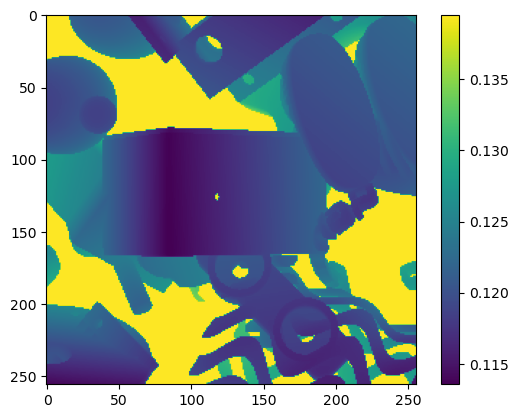

In [17]:
plt.imshow(depth)
plt.colorbar()

In [11]:
depth[:, :, None].shape

NameError: name 'depth' is not defined

In [12]:
np.max(depth[:,0])

NameError: name 'depth' is not defined